# A/B Experiment

## Introduction

In order to determine if there's any significant difference in the recommenders click through rate, and more importantly if the challenger recommender, we need to design and run an A/B experiment. 

This experiment will consist in splitting the traffic between the two different recommender systems in order to randomly obtain recommendations for visiting users. Each recommender system will then be evaluated using the click-through rate metric i.e. what is the proportion of users that clicked on the recommendations presented to them for each recommender ? 

## One tailed or two tailed ?


This is a debate that has been going on for a very long time and that has been fought by famous academics and indutrials. 

A one-tailed Z-test can be used for the hypothesis test, when we are only interested in proving one possible outcome which is in this case that the recommendation rate is higher with the challenger model.
We are not interested in proving the outcome where the baseline model might be better.

One rule of thumb is that if there are actions undertaken as a result of a significant difference, and they are the same whether A or B wins, then a two-tailed test should be used, as we are interested in knowing whether there is a difference or not, and chosing whichever A or B is better.

While if we are "challenging" an existing setup and want to determine whether the improvement will lead to an increase or decrease in some quantity, and we will replace the existing setup with the newest improvement depending on the test, then one-tailed should be used.

#### But having a two tailed test would actually reject the $H_0$ hypothesis in one direction with 2.5% significance level !
Even though the two tailed test with a 5% significance level divides the 5% for every direction of change, but it increases the number of users needed to run the experiment, as seen below, which often in practice is the main concern.

More about this one vs two tail problem in [[1]](#1) and [[2]](#2)


So, going with the one tailed test, we state the following two hypotheses:

$H_0$ : The baseline and challenger model yields in average the same recommendation click-through rate ($p_2 = p_1$)

$H_1$ : The challenger model yields in average a higher recommendation click-through rate than the baseline model ($p_2 > p_1$)

After stating the hypotheses, we need to estimate the sample size we need for the experiment 

## Estimating needed sample size

One of the most accurate and commonly used way to estimate sample size n using the statistical significance and power and the minimum detectable effect (MDE) is the following formula from [[1]](#1):

$$ n'=\frac{\left (  z_{\alpha}\sqrt{\strut2\bar{P}\bar{Q}} + z_{\beta}\sqrt{\strut P_1Q_1 + P_2Q_2}\right )^{2}}{\left ( P_2 - P_1 \right )^2}$$

$$ n = \dfrac{n'}{4}\left ( 1+\sqrt{\strut1+\dfrac{4}{n'\left | P_2 - P_1 \right |}}\right)^2 $$

where :

- $n'$ is sample size without correction and $n$ is sample size with the correction
- $P_1$ and $P_2$ are the population proportions (baseline and expected)
- $Q_i = 1 - P_i$/
- $\bar{P}=\frac{P_1 + P_2}{2}$
- $z_{\alpha}$ is the cutoff value of probability $\alpha$ ($\alpha$ the probability of a type I error) in the standard normal distribution
- $z_{\beta}$ is the cutoff value of probability $\beta$ in the standard normal distribution ($\beta$ the probability of a type II error, or 1 - power)

the formula has been adapted for one tailed tests, simply by changing $z_\alpha/2$ to $z_\alpha$


It is quite easy to change this formula to one that is expressed in function of $p$, the baseline proportion (or probability) and the MDE $\Delta$ by setting $p_1=p$ and $p_2 = p_1 + \Delta$.

In the case presented, $P_1$, the (known) baseline probability is 7% (obtained by previous experiment).
The minimum detectable effect needs to be set by considering the business aspect of the problem, namely, what improvement would be a good outcome if statistically proven or what improvement would be enough to justify the switch to the tested effect. Any improvement smaller than does not need to be statistically detectable as it anyway won't be a success on the business aspect. It is worth noting that the smaller the needed minimum detectable effect, the larger the population size; the reason why it should be chosen wisely. Also, it should be chosen conservatively as there's a possibility that the baseline probability slightly changes during the experiment. Finally, it's important to keep in mind that this MDE is a detectable effect that can be towards both directions, it can be an improvement but also (hopefully not) a deterioration on the CTR.

One positive effect of using one tailed tests instead of two tailed tests is that it decreases the required sample size for a given significance level and MDE.

#### Does that mean that if the resulting effect is less than 4%, it won't be detected ?

No, although this a common misconseption, it means that if the resulting effect is less than 4%, the power of experiment will be less than 90%. That's why a lot of publications started refering to the MDE as Minimum Reliably Detectable Effect (MRDE). More about MDE [here](https://towardsdatascience.com/how-to-set-the-minimum-detectable-effect-in-ab-tests-fe07f8002d6d).

In [1]:
import numpy as np
import scipy.stats
import math
import matplotlib.pyplot as plt
from ipywidgets import interact

In [2]:
def z_value(p):
    return scipy.stats.norm.ppf(1 - p)

In [3]:
def sample_size(p1, p2, alpha, beta):
    if p1 == p2:
        raise Exception("p1 and p2 can not be equal")
    q1 = 1 - p1
    q2 = 1 - p2
    pb = (p1+p2) / 2
    qb = (q1+q2) / 2
    npr = (((z_value(alpha)*math.sqrt(2*pb*qb))+(z_value(beta)*math.sqrt(p1*q1+p2*q2)))**2)/((p2-p1)**2)
    n = npr*0.25*(1+math.sqrt(1+4/(npr*abs(p2-p1))))**2
    return math.ceil(n)

In [4]:
sample_size(0.07, 0.22, 0.05, 0.1)

106

Here we can play around the p1, p2, alpha and beta values to understand better how does the sample size vary with those parameters

In [5]:
@interact(p1=(0, 1, 0.01), p2=(0, 1, 0.01), alpha=(0, 1, 0.01), beta=(0, 1, 0.01))
def sample_size_interact(p1=0.32, p2=0.36, alpha=0.05, beta=0.1):
    return "Sample size :  {}".format(sample_size(p1, p2, alpha, beta))

interactive(children=(FloatSlider(value=0.32, description='p1', max=1.0, step=0.01), FloatSlider(value=0.36, d…

## Recommenders experiment

Considering the case presented here, the baseline click-through rate is reported to be 7%. The objective of the team is to increase the recommender click-through rate to at least 4% or else the change wouldn't be worth implementing. So the minimum desired expected proportion is 11%

Exploring the required sample size for a p1 = 7%, function of p2 

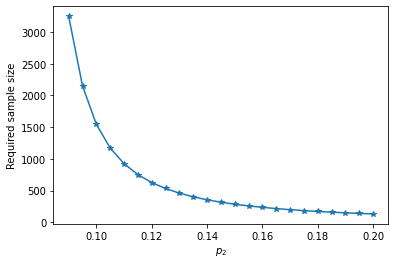

In [6]:
possible_p2 = list(np.arange(0.09, 0.20, 0.005))
p2_samples = [sample_size(0.07, p2, 0.05, 0.1) for p2 in possible_p2]
plt.plot(possible_p2, p2_samples, marker='*')
plt.xlabel("$p_2$")
plt.ylabel("Required sample size")
plt.show()

Exploring the required sample size for a p1 = 7%, p2 = 11% (MDE = 4%), function of power

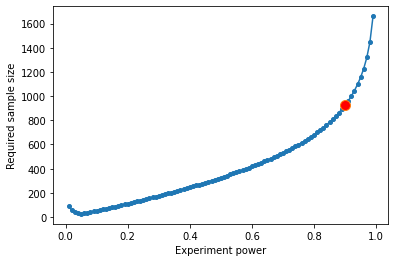

In [7]:
power = list(np.arange(0.01, 1, 0.01))
power_sample = [sample_size(0.07, 0.11, 0.05, 1-p) for p in power]
plt.plot(power, power_sample, marker='o', ms=4)
plt.plot([0.9], [sample_size(0.07, 0.11, 0.05, 0.1)], marker='o', ms=10, mfc='r')
plt.xlabel("Experiment power")
plt.ylabel("Required sample size")
plt.show()

In [8]:
sample_size(0.07, 0.11, 0.05, 0.1)

925

To reliably run the experiment with a 5% significance-level (5% probability of type I error, rejecting $H_0$ while it is actually true) and 90% power (10% probability of type II error, failing to reject $H_0$) the sample size must be at least **925 user** per recommender. 

The experiment will be ran until each recommender has been tested with 930 users.

## Note

A more generalised experiment model in this case is the $\chi^2$ statistic goodness of fit test. It generalises better as it allows to test multiple interactions. For example, in case we would want to test three different models at once (an A/B/C test) or even more complex testing as studying user conversion on a subscription based product by defining three (or more) outcomes : No subscription, 1-month subscription, 3-months subscription. 
Actually, in the 2x2 case (eg. A/B, Click/No Click), a $\chi^2$ goodness of fit test is equivalent and yields the same result as a z-test (the $\chi^2$ statistic is the same as a $z^2$ statistic), and could have been used here. The only difference is that it is always a two tailed test

## References
<a id='1'>[1]</a> Chris Stucchio, One tailed vs two tailed A/B tests - your decision procedure is the deciding factor [blog post](https://www.chrisstucchio.com/blog/2015/one_tailed_and_two_tailed_tests.html)

<a id='2'>[2]</a> Dominic Sando, Why two-sided testing is reducing your A/B testing program’s impact by 25%
[article](https://dominicsando.medium.com/why-two-sided-testing-is-reducing-your-a-b-testing-programs-impact-by-25-11d72276446a)

<a id='2'>[3]</a> Fleiss, J. L. (1973). Statistical methods for rates and proportions. p. 75 New York: J. Wiley.